In [1]:
from firebase_admin import credentials, storage, firestore
import firebase_admin
from typing import Dict, Union, List, Optional, Set, Callable

__app_initialize_dict: Dict[str, str] = {
    "databaseURL": "https://stepnavigation-default-rtdb.firebaseio.com/",
    "storageBucket": "stepnavigation.appspot.com",
}
firebase_creds = credentials.Certificate("/Users/pruvolo/Downloads/stepnavigation-firebase-adminsdk-at42e-31834e1b6d.json")
app = firebase_admin.initialize_app(firebase_creds, __app_initialize_dict)

In [5]:
def download_full_map(app, map_prefix):
    db = firestore.client()
    cloud_anchors = None
    connections = None
    for collection in db.collections():
        if collection.id == "{map_prefix}_cloud_anchors".format(map_prefix=map_prefix):
            cloud_anchors = collection
        elif collection.id == "{map_prefix}_connections".format(map_prefix=map_prefix):
            connections = collection
    if connections is None or cloud_anchors is None:
        print("missing collection")
    cloud_anchor_data = dict(map(lambda cloud_anchor: (cloud_anchor.id, cloud_anchor.get().to_dict()), cloud_anchors.list_documents()))
    connections_data = dict(map(lambda connection: (connection.id, connection.get().to_dict()), connections.list_documents()))
    return cloud_anchor_data, connections_data

In [128]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def print_connectivity(cloud_anchor_data, cloud_anchor_id):
    cloud_anchor = cloud_anchor_data[cloud_anchor_id]
    print('  ',cloud_anchor['name'])
    for connection in cloud_anchor.get('connections', []):
        if connection['toID'] in cloud_anchor_data:
            print('    connected to: {toName}'.format(toName=cloud_anchor_data[connection['toID']]['name']))
        else:
            print('    connected to deleted node')

def print_all_connectivity(cloud_anchor_data, connections_data):
    print('Cloud Anchors:')
    for cloud_anchor_id in cloud_anchor_data.keys():
        print_connectivity(cloud_anchor_data, cloud_anchor_id)
    
    print('')
    print('Connections collection:')
    for d in list(connections_data.values()):
        try:
            from_name = cloud_anchor_data[d['fromID']]['name']
        except:
            from_name = 'deleted anchor'

        try:
            to_name = cloud_anchor_data[d['toID']]['name']
        except:
            to_name = 'deleted anchor'
        print('  {from_name} -> {to_name}'.format(from_name=from_name, to_name=to_name))

cloud_anchor_data, connections_data = download_full_map(app, 'MAC Demo')
print_all_connectivity(cloud_anchor_data, connections_data)

Cloud Anchors:
   Evelyn’s Seat 2
   Evelyn’s seat - testing
    connected to: MAC 209
    connected to: MAC 209 couch
    connected to: MAC 209
   Re:work studios
    connected to: MAC Elevators (2nd Floor)
   NECO First Floor Elevator
   MAC 209
    connected to: MARTI the robot
    connected to: MAC 213-218 junction
    connected to: MAC Elevators (2nd Floor)
    connected to: MAC Elevators (2nd Floor)
    connected to: MAC Elevators (2nd Floor)
    connected to: MAC Elevators (2nd Floor)
    connected to: MAC Elevators (2nd Floor)
   Office of the Ombuds 
   NECO Occupational Health Center
   CC Door near MAC
    connected to: CC Elevators (1st Floor)
   MAC Door (Near CC)
    connected to: MAC Elevators (1st Floor)
   MARTI the robot
    connected to: MAC 213-218 junction
   Center for Sexual Assault Response & Prevention
   MAC Elevators (2nd Floor)
    connected to: Re:work studios
    connected to: MAC Elevators (1st Floor)
    connected to: MAC 209
    connected to: MARTI the 

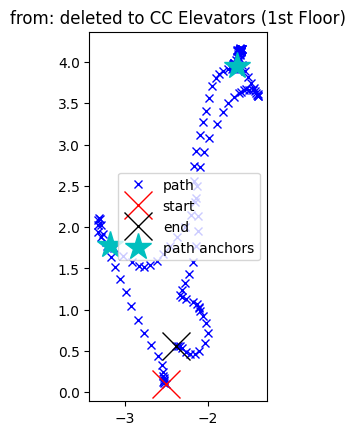

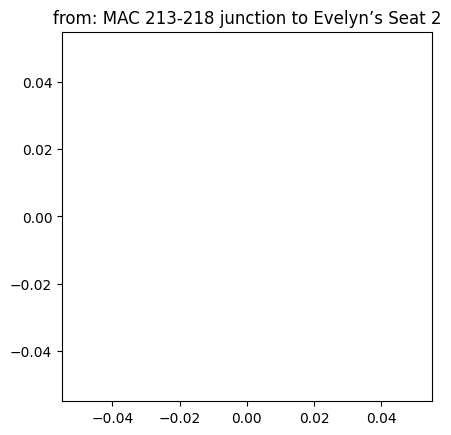

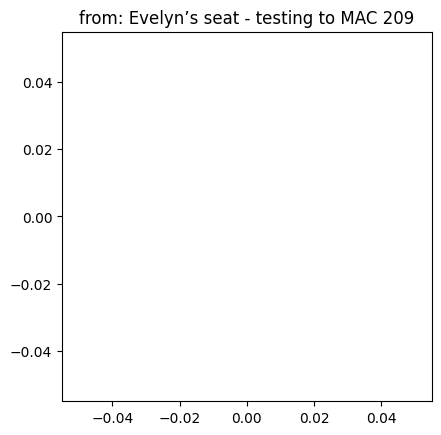

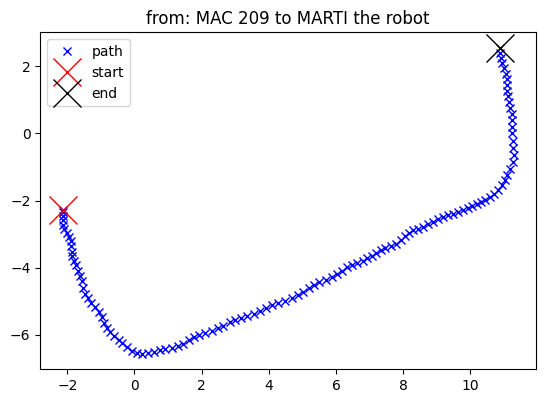

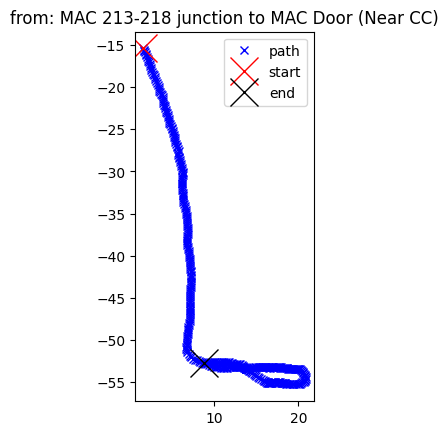

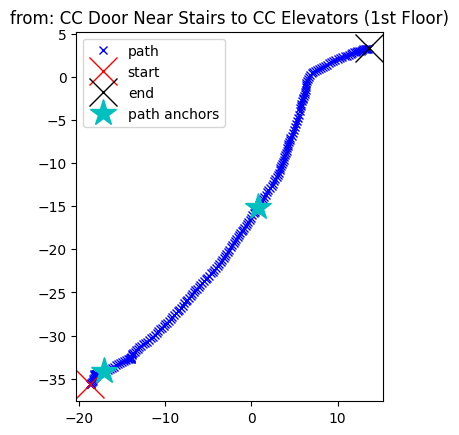

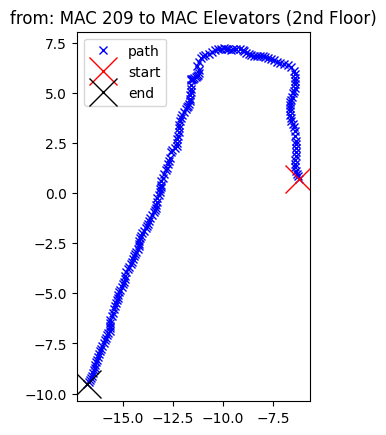

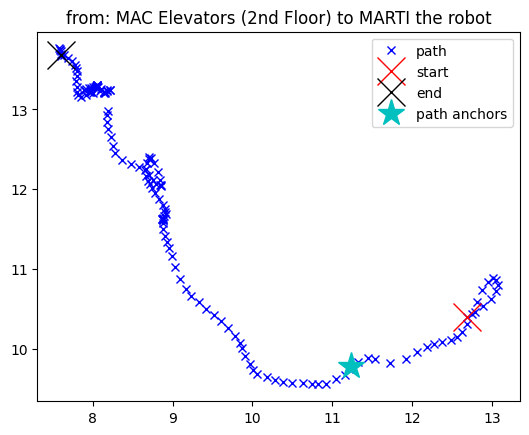

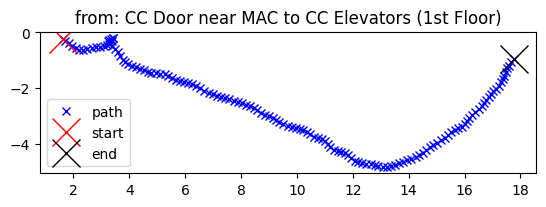

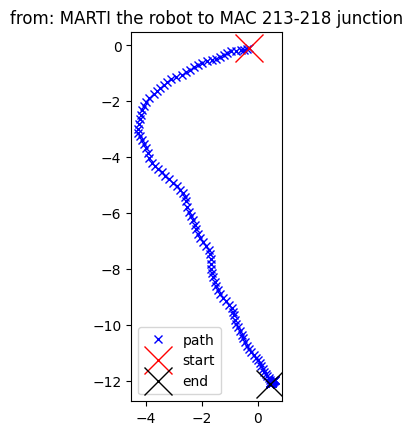

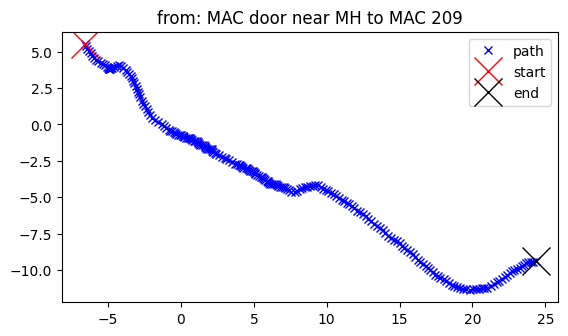

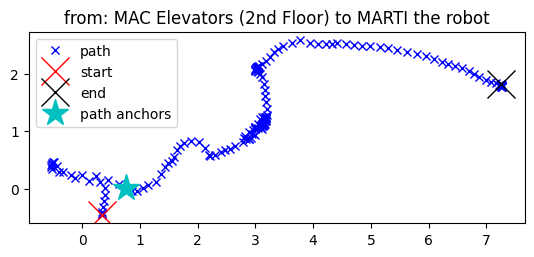

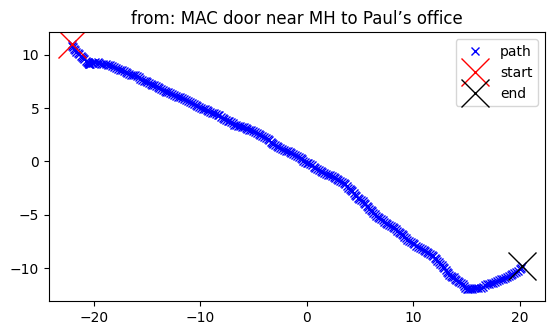

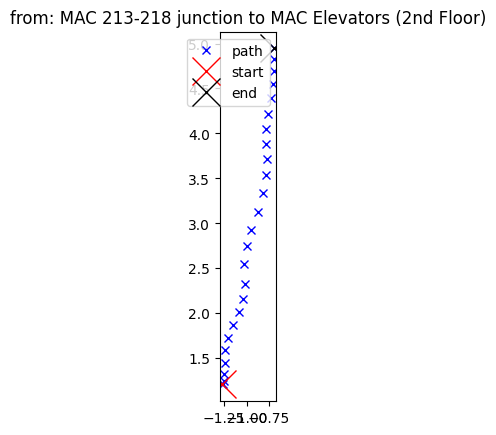

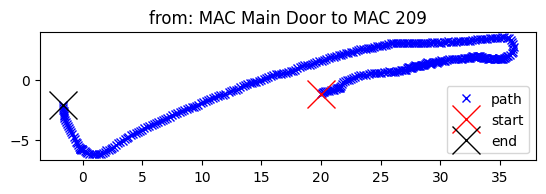

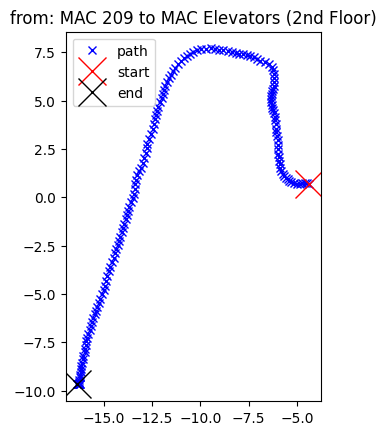

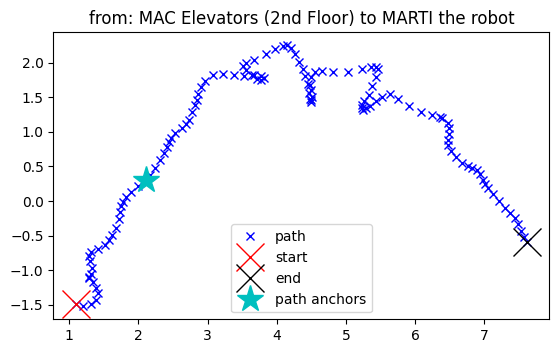

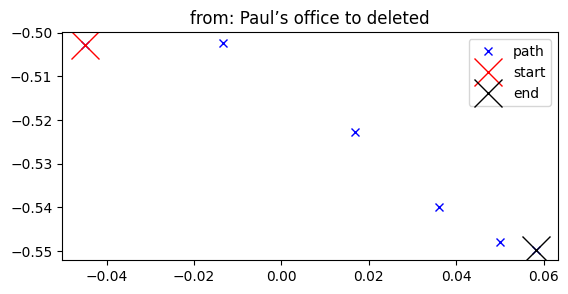

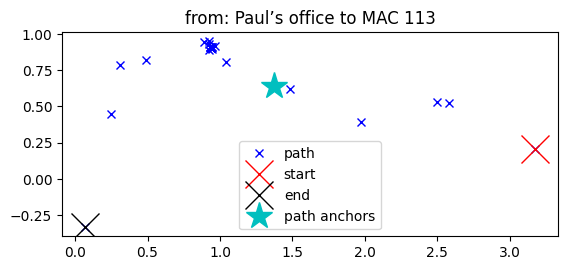

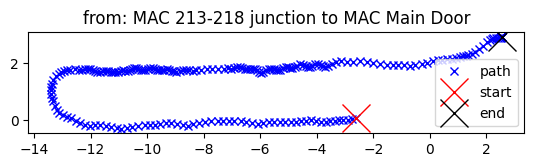

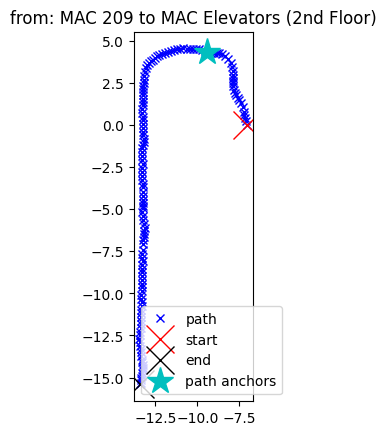

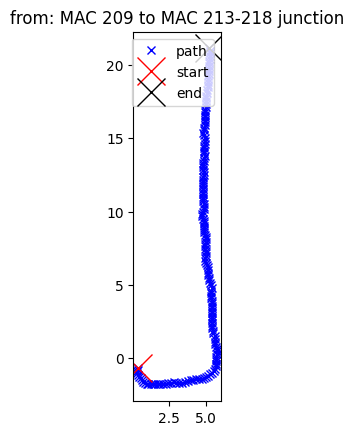

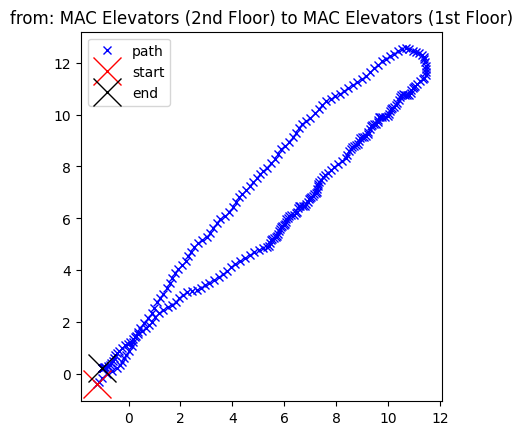

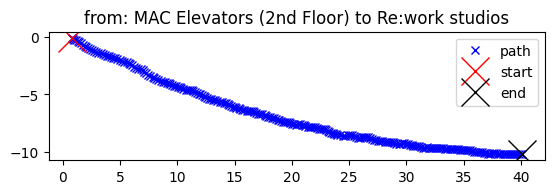

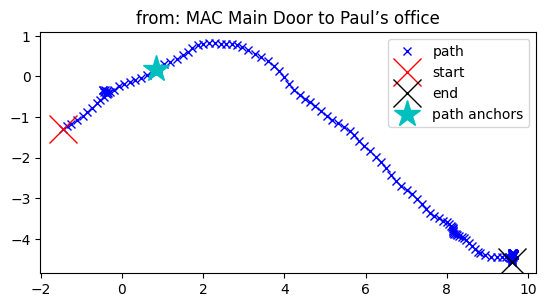

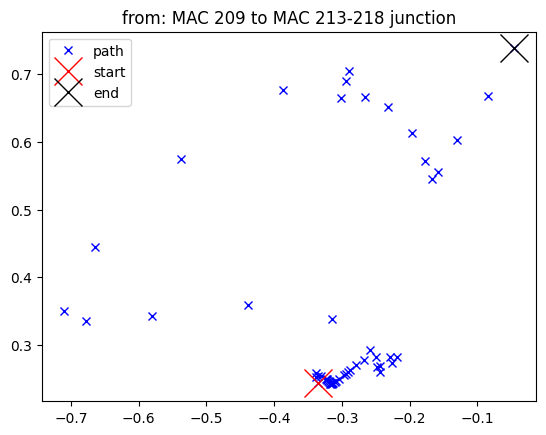

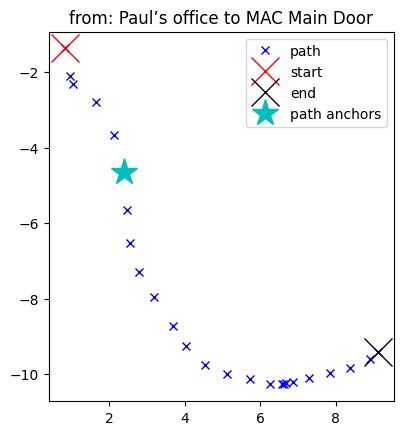

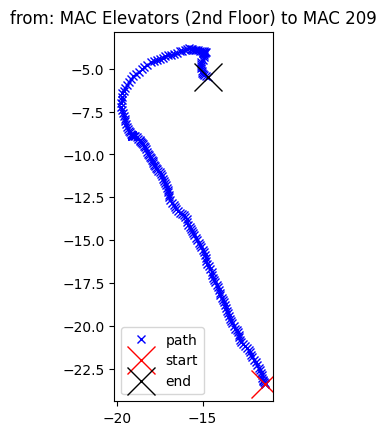

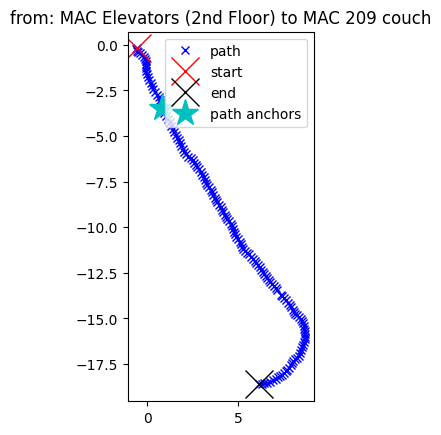

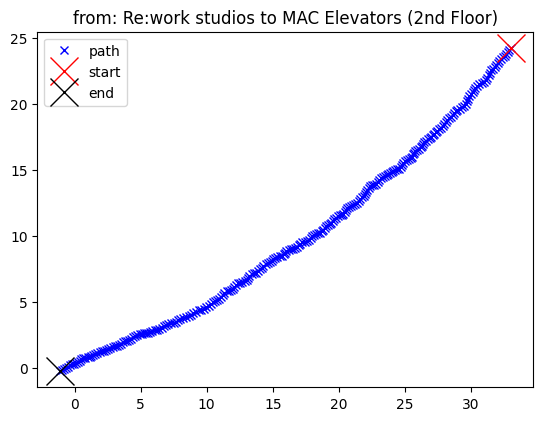

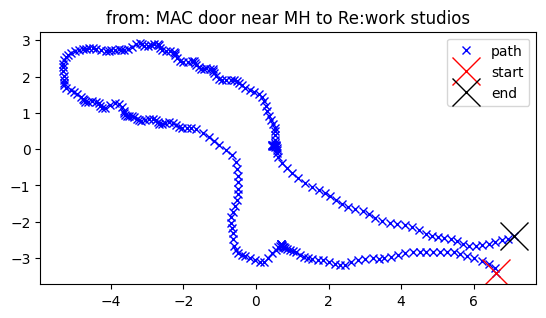

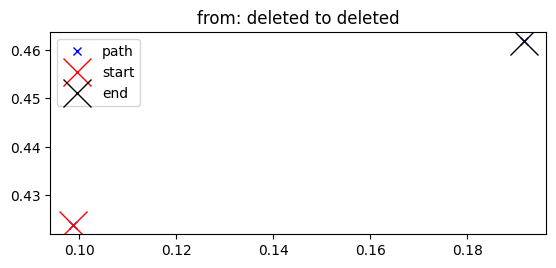

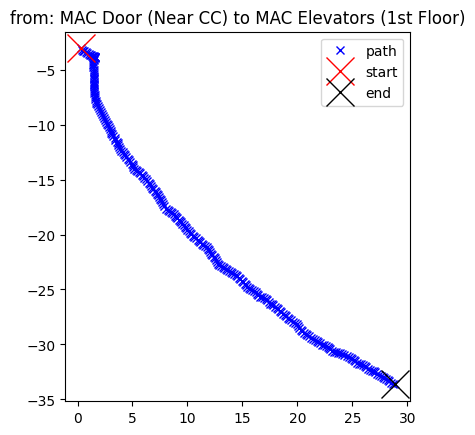

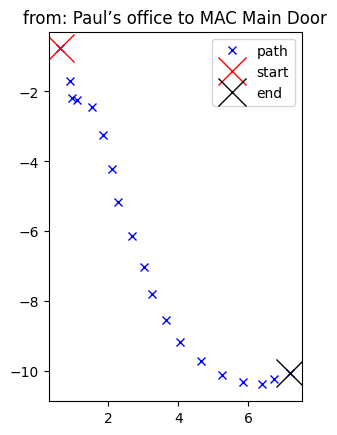

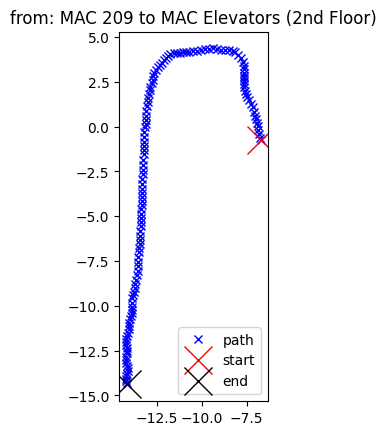

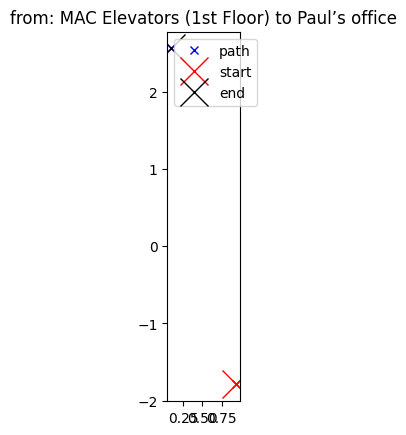

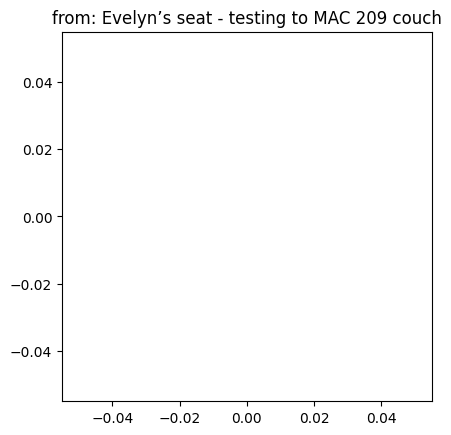

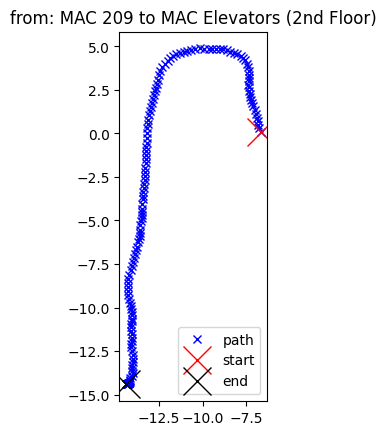

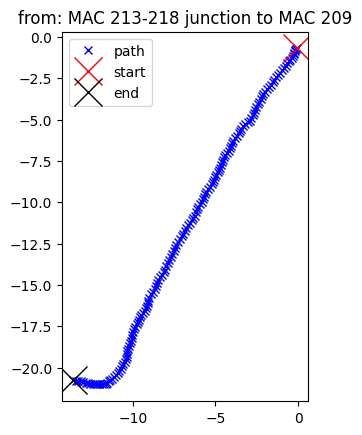

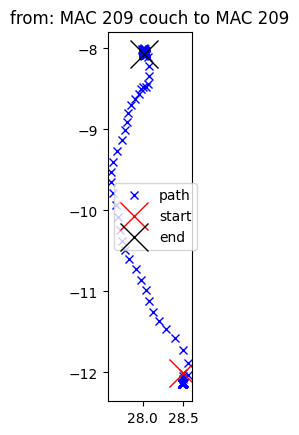

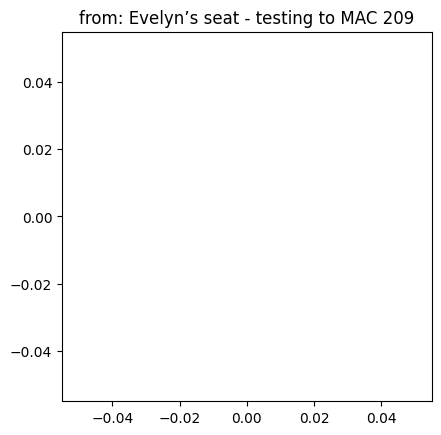

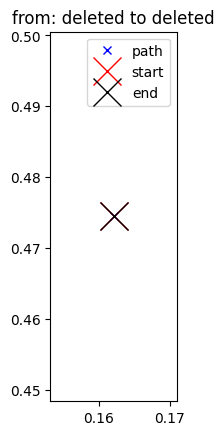

In [129]:
import numpy as np
import matplotlib.pyplot as plt

all_paths = []

for identifier, connection in connections_data.items():
    start_id = connection['fromID']
    start_pose = np.array(connection['fromPose']).reshape((4,4)).T
    if start_id in cloud_anchor_data:
        start_name = cloud_anchor_data[start_id]['name']
    else:
        start_name = 'deleted'
    end_id = connection['toID']
    end_pose = np.array(connection['toPose']).reshape((4,4)).T
    if end_id in cloud_anchor_data:
        end_name = cloud_anchor_data[end_id]['name']
    else:
        end_name = 'deleted'
    path_raw = np.array(connection['path'])
    path = path_raw.reshape(-1, 4, 4).swapaxes(1,2)
    fig, axes = plt.subplots(1,1)
    plt.title('from: {start_name} to {end_name}'.format(start_name=start_name, end_name=end_name))
    axes.plot(path[:,2,-1], path[:,0,-1],'bx')
    if path.shape[0]:
        axes.plot(path[0,2,-1], path[0,0,-1],'rx',markersize=20)
        axes.plot(path[-1,2,-1], path[-1,0,-1],'kx',markersize=20)
        path_anchors_raw = connection['pathAnchors']
        path_anchors_before_axis_swap = np.array(list(map(lambda x: np.array(x).reshape(4,4), path_anchors_raw.values())))
        if path_anchors_before_axis_swap.size:
            path_anchor_poses = path_anchors_before_axis_swap.swapaxes(1,2)
            axes.plot(path_anchor_poses[:,2,-1], path_anchor_poses[:,0,-1], 'c*', markersize=20)
        axes.legend(['path', 'start', 'end', 'path anchors'])
    all_paths.append((start_id, start_pose, path, end_id, end_pose))

    axes.set_aspect('equal', 'box')
    plt.show()

<Figure size 640x480 with 0 Axes>

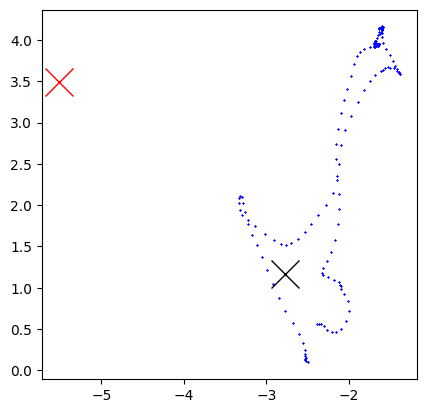

<Figure size 640x480 with 0 Axes>

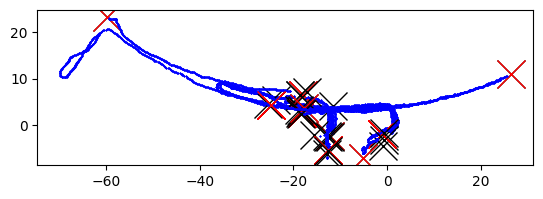

<Figure size 640x480 with 0 Axes>

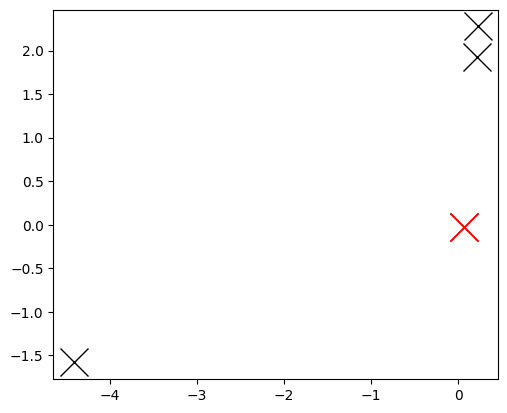

<Figure size 640x480 with 0 Axes>

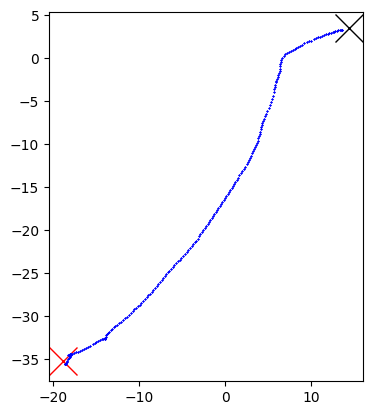

<Figure size 640x480 with 0 Axes>

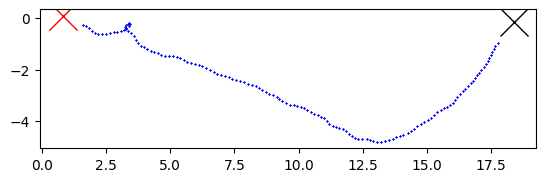

<Figure size 640x480 with 0 Axes>

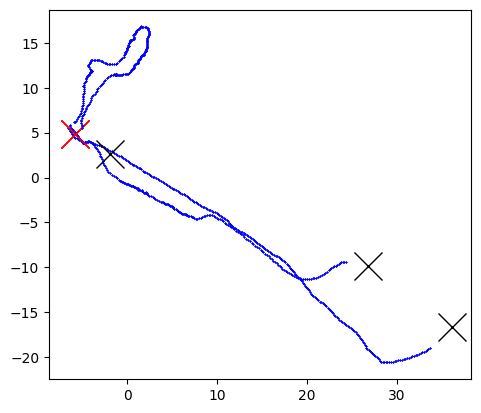

<Figure size 640x480 with 0 Axes>

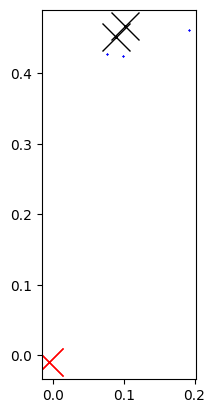

In [136]:
# this will map from cloud anchor identifiers to poses
established_poses = {}

def process_paths(all_paths, isFirst, established_poses):
    for c in range(len(all_paths)):
        (start_id, start_pose, path, end_id, end_pose) = all_paths[c]
        if start_id not in established_poses and not isFirst:
            continue
        # TODO: could clean this up probably with some fancy get / default value
        if start_id not in established_poses:
            aligner = np.eye(4)
            established_poses[start_id] = start_pose
            start_pose_consensus = start_pose
        else:
            start_pose_consensus = established_poses[start_id]
            aligner = start_pose_consensus @ np.linalg.inv(start_pose)

        if end_id not in established_poses:
            established_poses[end_id] = aligner @ end_pose

        ax.plot(start_pose_consensus[2,-1], start_pose_consensus[0,-1],'rx', markersize=20)
        for i in range(path.shape[0]):
            aligned_path_pose = aligner @ path[i,:,:].squeeze()
            ax.plot(aligned_path_pose[2,-1], aligned_path_pose[0,-1],'bx', markersize=1)
        aligned_end_pose = aligner @ end_pose
        ax.plot(aligned_end_pose[2,-1], aligned_end_pose[0,-1],'kx', markersize=20)
        del all_paths[c]
        return

all_paths_copy = all_paths[:]
while len(all_paths_copy):
    plt.figure()
    fig, ax = plt.subplots(1,1)
    for i in range(len(all_paths_copy)):
        process_paths(all_paths_copy, i == 0, established_poses)
    ax.set_aspect('equal', 'box')
    plt.show()
